# Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [173]:
!which python

/home/adripinto/.local/share/virtualenvs/social-media-analysis-B4dJjkUW/bin/python


# Install dependencies:

In [174]:
# install_packages = False
# if install_packages:    
#     !conda install -c conda-forge umap-learn -y
#     !conda install -c conda-forge scikit-learn-extra -y

# Imports

In [175]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [176]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

# Set pandas print options
This will improve readability of printed pandas dataframe.

In [177]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [181]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [182]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [183]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [184]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.45856607
n_clusters: 102 silhouette_avg: 0.2800663
n_clusters: 202 silhouette_avg: 0.28090265
n_clusters: 302 silhouette_avg: 0.24856493
n_clusters: 402 silhouette_avg: 0.179613


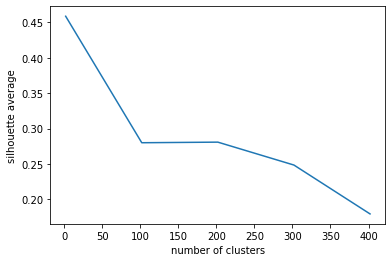

In [185]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=500
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [186]:
number_of_clusters =  100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 99     1
82     1
70     1
97     1
96     1
98     1
57     1
84     1
20     1
9      1
27     1
86     1
77     1
78     1
29     1
90     2
91     2
13     2
95     2
23     2
45     2
53     2
35     2
48     2
87     3
71     3
21     3
79     3
15     3
85     3
88     3
67     3
17     3
89     3
50     3
41     3
36     3
65     3
55     3
24     4
73     4
75     4
60     4
56     4
94     4
83     4
80     4
0      4
11     4
76     4
31     4
3      4
38     5
52     5
93     5
5      5
28     5
22     5
59     5
18     5
34     5
66     5
10     5
68     6
37     6
2      6
51     6
1      7
32     7
46     7
16     7
14     7
19     7
7      7
63     8
30     8
26     8
81     8
49     9
69     9
42     9
64     9
62     9
58     9
92     9
54    10
40    10
61    11
12    13
44    13
43    13
25    13
72    14
6     14
8     14
74    15
4     17
47    20
39    21
33    22
Name: label_kmedoids, dtype: int64


In [187]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [188]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/home/adripinto/.local/share/virtualenvs/social-media-analysis-B4dJjkUW/lib/python3.8/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

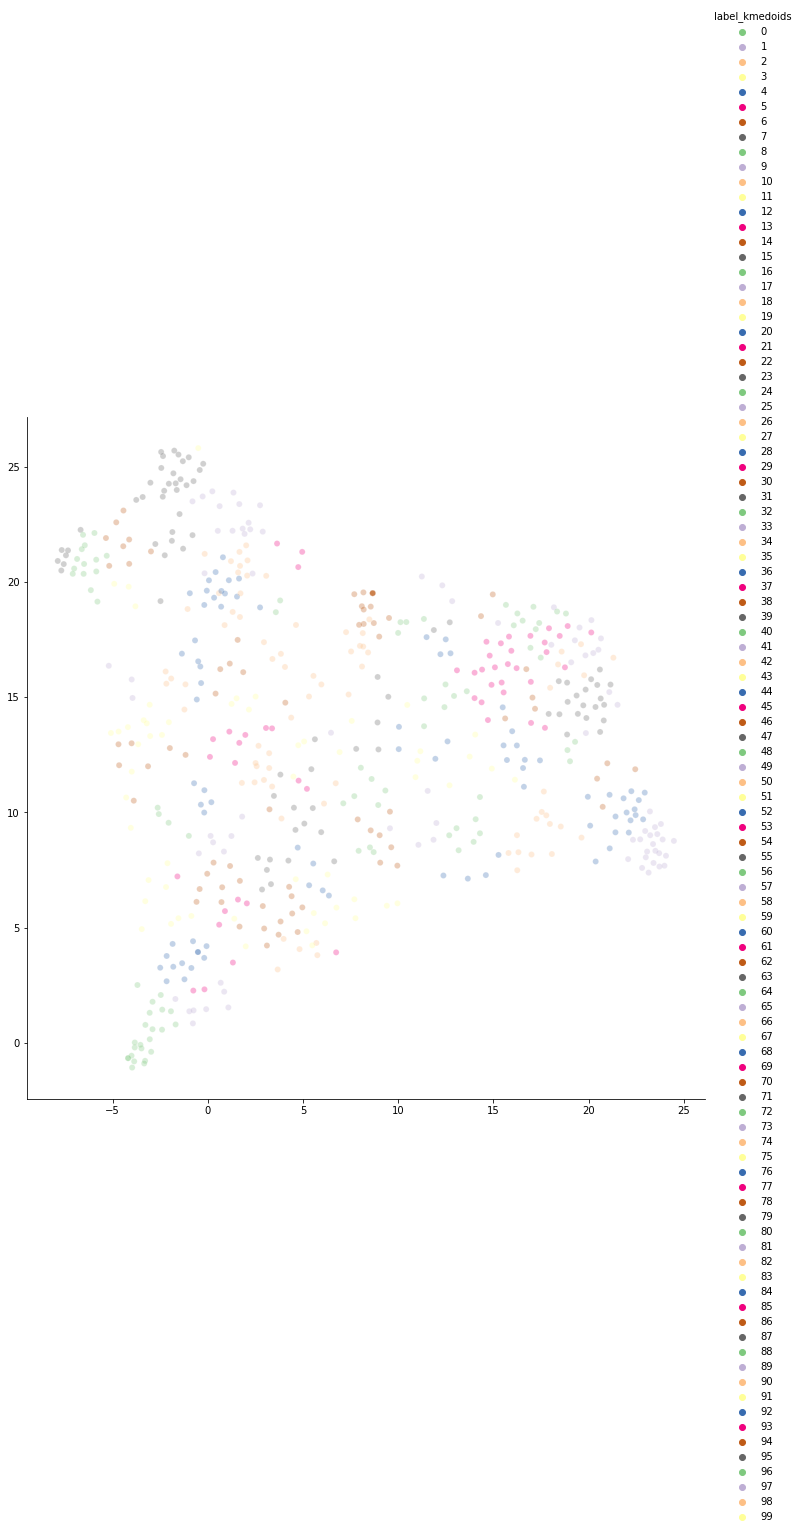

In [189]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

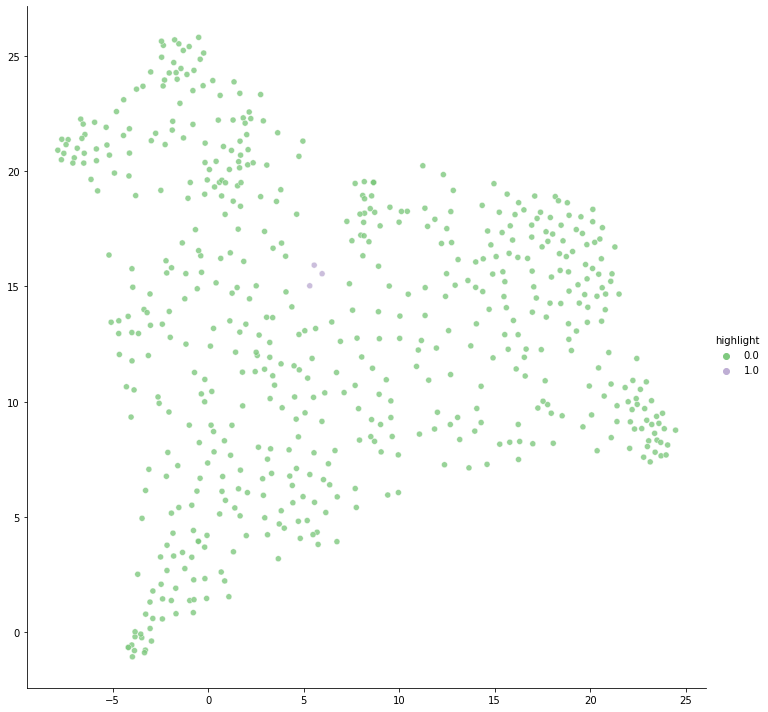

In [190]:
## Choose a cluster to higlight:
cluster_num = 50

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [191]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
240,2020-11-29 19:43:08,Hugh Jones,"@Canna ""The proof anything can be bought"" Or the proof that people can have a different opinion from YOU. ""You're the ones who is going to live in this world. You deserve it. "" What, normality?",1,"@ ""The proof anything can be bought"" Or the proof that people can have a\ndifferent opinion from YOU. ""You're the ones who is going to live in this\nworld. You deserve it. "" What, normality?\n\n",-1.0,0,0.000000e+00,0.0
79,2020-08-17 01:46:08,Peter - Pedro Gerasimon,"We need to understand this is not a Greta vs. Naomi contest. <br />They are only the messengers. <br />I would say Greta is the voice of the world&#39;s scientific community. <br />Naomi is clearly the voice of white nationalists, afraid to lose their comfort zone. <br />Everyone who is well informed and has a basic understanding of the human induced transformation of the atmospheric conditions of our planet by unearthing and burning a substance absent in the atmospheric mix for millions of years comprehends clearly the facts and their consequences. <br />The denial of climate change does not have a solid base, in fact, not even a business case and aims to benefit only those who want to produce, sell and burn more fossil fuels. This is a clear case of risk assessment, survival and sustainability and NOT political football.",0,"We need to understand this is not a Greta vs. Naomi contest. \nThey are only the messengers. \nI would say Greta is the voice of the world's scientific community. \nNaomi is clearly the voice of white nationalists, afraid to lose their comfort\nzone. \nEveryone who is well informed and has a basic understanding of the human\ninduced transformation of the atmospheric conditions of our planet by\nunearthing and burning a substance absent in the atmospheric mix for millions\nof years comprehends clearly the facts and their consequences. \nThe denial of climate change does not have a solid base, in fact, not even a\nbusiness case and aims to benefit only those who want to produce, sell and\nburn more fossil fuels. This is a clear case of risk assessment, survival and\nsustainability and NOT political football.\n\n",-1.0,1,0.000000e+00,0.0
103,2020-07-12 09:55:48,Phil Dobson,"<b>Nice!</b> Food can&#39;t grow without CO2! Humans can&#39;t live without breathing out CO2! It&#39;s a symbiotic relationship. <b>Consentrate on real pollution: Plastic in Oceans &amp; Nuclear radiation</b> (unlike CO2, which plants depend on &amp; animals breath out, Nuclear radiation is harmful)",0,"**Nice!** Food can't grow without CO2! Humans can't live without breathing\nout CO2! It's a symbiotic relationship. **Consentrate on real pollution:\nPlastic in Oceans & Nuclear radiation** (unlike CO2, which plants depend on &\nanimals breath out, Nuclear radiation is harmful)\n\n",-1.0,2,0.000000e+00,0.0
174,2020-05-18 01:35:26,D S,Why listen to Children....,0,Why listen to Children....\n\n,-1.0,3,2.980232e-07,0.0
412,2020-04-02 09:04:59,ben,"@Kristina Jones he confirmed Copernicus' hypothesis that the earth was rotating around the sun in like 1500s he also is regarded as the Father of modern day astronomy, building the first refactor telescope ( i have a nice dobsonian refractor, thanks Gal) He discovered moons around Venus and in so doing he proved the heliocentric model.(firstly postured by Aristarchus in 270bc, reaffirmed by Copernicus and finally observed and confirmed by Galileo) He invented a bunch of items that paved the way for their modern counterparts such as thermometer and compass. He is also responsible for the modern scientific method and prior to this they used the ""argument of authority"" which is shit. Just because i have a degree and i say it its true....No, we need to see the evidence and then try and prove you wrong, when we cant that hypothesis is ""accepted"" or ""refuted"" if we can for a more plausible explanat

In [192]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  4 mean distance from center:  0.0006601214408874512 Proportion of replies: 100.0
1 number of samples:  7 mean distance from center:  0.0009264264917874243 Proportion of replies: 57.142857142857146
2 number of samples:  6 mean distance from center:  0.001097718904929934 Proportion of replies: 50.0
3 number of samples:  4 mean distance from center:  0.0014603137969970703 Proportion of replies: 50.0
4 number of samples:  17 mean distance from center:  0.0009038869393407367 Proportion of replies: 82.3529411764706
5 number of samples:  5 mean distance from center:  0.0006735324859619141 Proportion of replies: 60.0
6 number of samples:  14 mean distance from center:  0.0005590064120042371 Proportion of replies: 21.428571428571427
7 number of samples:  7 mean distance from center:  0.0002384185791015625 Proportion of replies: 42.857142857142854
8 number of samples:  14 mean distance from center:  0.0002707753765207599 Proportion of replies: 35.714285714285715
9 number of

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [193]:
# Choose a cluster to print
cluster_number = 18
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 5
Average Distance from cluster center: 7.18832e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
47,2020-10-27 19:52:02,Shoot Tehckx,"Wie kann man so dumm sein als Human und sich mal denken, man könnte the Fight gegen Mutter Natur zu gewinnen?🤭🤦🏽‍♂️<br />Die ignorante Menschen denken die können gegen die Natur die Kämpfe gewinnen.😂🚫",0,"Wie kann man so dumm sein als Human und sich mal denken, man könnte the Fight\ngegen Mutter Natur zu gewinnen?🤭🤦🏽‍♂️ \nDie ignorante Menschen denken die können gegen die Natur die Kämpfe\ngewinnen.😂🚫\n\n",-1.0,18,0.000000e+00,0.0
61,2020-09-28 16:31:23,Mirror of Society,vladolf putlers propagandasender mit bezahlter propaganda... niedlich aber greta geht ihren weg und ihr spinner könnt mal so gar nix dagegen machen...,0,vladolf putlers propagandasender mit bezahlter propaganda... niedlich aber\ngreta geht ihren weg und ihr spinner könnt mal so gar nix dagegen machen...\n\n,-1.0,18,1.192093e-07,0.0
112,2020-06-27 05:33:40,TommiG,Klimawandel? Höhere Steuerbelastungen müssen doch irgendwie gerechtfertigt werden!! 🤔,0,Klimawandel? Höhere Steuerbelastungen müssen doch irgendwie gerechtfertigt\nwerden!! 🤔\n\n,-1.0,18,1.728535e-06,0.0
137,2020-06-04 18:27:22,Robert Fife,"Weiter so, Frau Seibt. Erst hassen sie Dich, dann beschimpfen sie Dich, dann gewinnst Du. Sie haben meine volle Unterstützung!",0,"Weiter so, Frau Seibt. Erst hassen sie Dich, dann beschimpfen sie Dich, dann\ngewinnst Du. Sie haben meine volle Unterstützung!\n\n",-1.0,18,4.410744e-06,0.0
155,2020-05-24 14:34:40,enna b,Sorry; my Englisch is not enough for the Video... and the comments ...<br />Good luck 👍👍👍👍👍😙🍀💞🍀⚘👌💥🔊🔊🔊💥🎶🎶🎶🙃😎<br />I&#39; m from Germany... Greetings,0,Sorry; my Englisch is not enough for the Video... and the comments ... \nGood luck 👍👍👍👍👍😙🍀💞🍀⚘👌💥🔊🔊🔊💥🎶🎶🎶🙃😎 \nI' m from Germany... Greetings\n\n,-1.0,18,2.968311e-05,0.0


# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [165]:
#which cluster would you like to assign labels to?
cluster_number = 3
#your label
label_manual = 'music'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [ ]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')